In [60]:
%load_ext autoreload
%autoreload 2

import importlib
from globals import *
import cell
import tissue

importlib.reload(cell)
importlib.reload(tissue)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<module 'tissue' from '/home/gili/weizmann/vertex_model/tissue.py'>

In [61]:
T = tissue.Tissue(cell_radius=cell_radius, num_cols=10, num_rows=10)

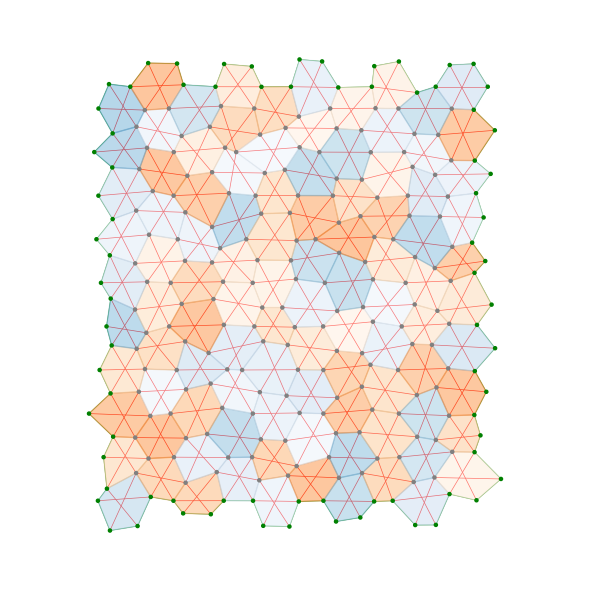

TypeError: getattr expected at least 2 arguments, got 1

In [62]:
# add some pertubations to check plotting
original_pos = nx.get_node_attributes(T.graph, 'pos').copy()

for cell in T.cells:
    cell.height = np.random.uniform(0.1, 1.0)
    pts = np.array([original_pos[n] for n in cell.nodes])
    center = pts.mean(axis=0)
    for i, n in enumerate(cell.nodes):
        x, y = original_pos[n]
        vx, vy = x - center[0], y - center[1]
        length = np.hypot(vx, vy) or 1.0
        ux, uy = vx/length, vy/length
        shift_x = np.random.normal(0, 0.2)
        shift_y = np.random.normal(0, 0.2)
        new_pos = (x + ux*shift_x, y + uy*shift_y)
        T.graph.nodes[n]['pos'] = new_pos

T.plot_tissue()

# check the compute forces method
T.compute_all_forces(['spring', 'line_tension'])
for node in T.graph.nodes:
    print(f"Node {node}: {T.graph.nodes[node]['force']}")